In [1]:
import nibabel as nb
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np 

import torch 
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from datetime import datetime

In [2]:
import torch
import torch.nn as nn
import torchvision
resnet = torchvision.models.resnet.resnet50(pretrained=True)

# https://github.com/kevinlu1211/pytorch-unet-resnet-50-encoder

class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """
        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, 1, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

unet = UNetWithResnet50Encoder()
inp = torch.rand((1, 3, 256, 256))
out = unet(inp)

In [3]:
out.shape

torch.Size([1, 1, 256, 256])

In [14]:
def MSE(img1, img2):
        cuadradoDeDif = ((img1 -img2) ** 2)
        suma = np.sum(cuadradoDeDif)
        cantPix = img1.shape[0] * img1.shape[1] #img1 and 2 should have same shape
        error = suma / cantPix
        return error

In [6]:
# Importo base de datos

noisyDataSet1_nii = sitk.ReadImage('./noisyDataSet1.nii')
img_noisyDataSet1 = sitk.GetArrayFromImage(noisyDataSet1_nii)

noisyDataSet2_nii = sitk.ReadImage('./noisyDataSet2.nii')
img_noisyDataSet2 = sitk.GetArrayFromImage(noisyDataSet2_nii)

groundTruth_nii = sitk.ReadImage('./groundTruth.nii')
img_groundTruth = sitk.GetArrayFromImage(groundTruth_nii)

print("noisyDataSet1 shape:",img_noisyDataSet1.shape)
print("noisyDataSet2 shape:",img_noisyDataSet2.shape)
print("groundTruth shape:",img_groundTruth.shape)

noisyDataSet1 shape: (1726, 344, 344)
noisyDataSet2 shape: (1726, 344, 344)
groundTruth shape: (1726, 344, 344)


In [8]:
# Reshape for training

img_noisyDataSet1 =img_noisyDataSet1[:,44:300,44:300]
img_noisyDataSet2 =img_noisyDataSet2[:,44:300,44:300]
img_groundTruth =img_groundTruth[:,44:300,44:300]

img_noisyDataSet1 = np.stack((img_noisyDataSet1,)*3, axis=-3)
img_noisyDataSet2 = np.stack((img_noisyDataSet2,)*3, axis=-3)
img_groundTruth = np.stack((img_groundTruth,)*3 ,axis=-3)

print(img_noisyDataSet1.shape)
print(img_noisyDataSet2.shape)
print(img_groundTruth.shape)

(1726, 3, 256, 256)
(1726, 3, 256, 256)
(1726, 3, 256, 256)


In [9]:
# Acoto conjuntos (OPCIONAL)

img_noisyDataSet1 =img_noisyDataSet1[30:50,:,:,:]
img_noisyDataSet2 =img_noisyDataSet2[30:50,:,:,:]
img_groundTruth =img_groundTruth[30:50,:,:,:]


In [10]:
# Entrenamiento #

# Loss and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0001)

# Conjunto de entrenamiento, testeo y validacion

train_noisyImage,test_noisyImage,train_groundTruth,test_groundTruth = train_test_split(img_noisyDataSet1, img_groundTruth, test_size=0.2)

valid_noisyImage = train_noisyImage[-5:,:,:,:]
valid_groundTruth = train_groundTruth[-5:,:,:,:]

train_noisyImage = train_noisyImage [:-5,:,:,:]
train_groundTruth = train_groundTruth[:-5:,:,:,:]

In [15]:
# Prueba con un slice 
if __name__ == '__main__':
    inputs = train_noisyImage[5]
    inputs = np.stack((inputs,)*3, axis=-3)
    inputs = torch.Tensor(inputs)
    out = unet(inputs)
    
gT = train_groundTruth[5]
gT = np.stack((gT,)*3, axis=-3)
gT = torch.Tensor(gT)

inputs_np = inputs.detach().numpy()
out_np = out.detach().numpy()
gT_np = gT.detach().numpy()

MSE_orig = MSE(inputs_np[0,0,:,:],gT_np[0,0,:,:])
MSE_test = MSE(out_np[0,0,:,:],gT_np[0,0,:,:])

print('MSE orig', MSE_orig)
print('MSE test', MSE_test)


# Guardar imgs en formato .nii

img_inputs = sitk.GetImageFromArray(inputs_np[0,0,:,:])
sitk.WriteImage(img_inputs,'inputsNoTrain.nii')

img_out = sitk.GetImageFromArray(out_np[0,0,:,:])
sitk.WriteImage(img_out,'outNoTrain.nii')


img_gT = sitk.GetImageFromArray(gT_np[0,0,:,:])
sitk.WriteImage(img_gT,'groundTruthNoTrain.nii')

MSE orig 0.3234834671020508
MSE test 2.103574514389038


In [16]:
# Codigo de pag Pythorch
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    for i in range(0, train_noisyImage.shape[0]):
        
        # Acondicionamiento de datos
        
        inputs = train_noisyImage[i]
        inputs = np.stack((inputs,)*3, axis=-3)
        inputs = torch.Tensor(inputs)
        
        trainGroundTruth = train_groundTruth[i]
        trainGroundTruth = np.stack((trainGroundTruth,)*3, axis=-3)
        trainGroundTruth = torch.Tensor(trainGroundTruth)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)
        loss = criterion(outputs, trainGroundTruth)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss en las ultimas 10 imagenes
            print('  image {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * ((train_noisyImage.shape[0])/10) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [17]:
# Initializing in a separate cell so we can easily add more epochs to the same run

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 20

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    unet.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    unet.train(False)

    running_vloss = 0.0
    for i in range(0, valid_noisyImage.shape[0]):
        
        vinputs = valid_noisyImage[i]
        vinputs = np.stack((vinputs,)*3, axis=-3)
        vinputs = torch.Tensor(vinputs)
        
        validGroundTruth = valid_groundTruth[i]
        validGroundTruth = np.stack((validGroundTruth,)*3, axis=-3)
        validGroundTruth = torch.Tensor(validGroundTruth)
        
        voutputs = unet(vinputs)
        vloss =  criterion(voutputs, validGroundTruth)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        unet_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(unet.state_dict(), unet_path)

    epoch_number += 1

EPOCH 1:


c:\users\ecyt\appdata\local\programs\python\python37\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([3, 3, 256, 256])) that is different to the input size (torch.Size([3, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  image 10 loss: 1.0822339594364165
LOSS train 1.0822339594364165 valid 1.5346254110336304


c:\users\ecyt\appdata\local\programs\python\python37\lib\site-packages\torch\nn\modules\module.py:1384: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  " and ".join(warn_msg) + " are deprecated. nn.Module.state_dict will not accept them in the future. "


EPOCH 2:
  image 10 loss: 0.34377382695674896
LOSS train 0.34377382695674896 valid 0.6948486566543579
EPOCH 3:
  image 10 loss: 0.24152788668870925
LOSS train 0.24152788668870925 valid 0.25853070616722107
EPOCH 4:
  image 10 loss: 0.20007792860269547
LOSS train 0.20007792860269547 valid 0.18785162270069122
EPOCH 5:
  image 10 loss: 0.18262776583433152
LOSS train 0.18262776583433152 valid 0.17436020076274872
EPOCH 6:
  image 10 loss: 0.1721140667796135
LOSS train 0.1721140667796135 valid 0.16874811053276062
EPOCH 7:
  image 10 loss: 0.16441905349493027
LOSS train 0.16441905349493027 valid 0.1646757423877716
EPOCH 8:
  image 10 loss: 0.15759579837322235
LOSS train 0.15759579837322235 valid 0.16254189610481262
EPOCH 9:
  image 10 loss: 0.15018845945596696
LOSS train 0.15018845945596696 valid 0.16150106489658356
EPOCH 10:
  image 10 loss: 0.14183291047811508
LOSS train 0.14183291047811508 valid 0.16271673142910004
EPOCH 11:
  image 10 loss: 0.13234228640794754
LOSS train 0.1323422864079475

In [19]:
# CONJUNTO DE ENTRENAMIENTO

if __name__ == '__main__':
    inputsTrain = train_noisyImage[5]
    inputsTrain = np.stack((inputsTrain,)*3, axis=-3)
    inputsTrain = torch.Tensor(inputsTrain)
    outTrain = unet(inputsTrain)
    
gTtrain = train_groundTruth[5]
gTtrain = np.expand_dims((gTtrain,)*3, axis=-3)
gTtrain = torch.Tensor(gTtrain)


inputsTrain_np = inputsTrain.detach().numpy()
outTrain_np = outTrain.detach().numpy()
gTtrain_np = gTtrain.detach().numpy()

# MSE antes y dsp

MSE_orig = MSE(inputsTrain_np[0,0,:,:],gTtrain_np[0,0,:,:])
MSE_test = MSE(outTrain_np[0,0,:,:],gTtrain_np[0,0,:,:])

print('MSE orig', MSE_orig)
print('MSE test', MSE_test)

MSE orig 0.3234834671020508
MSE test 0.07386448979377747


In [20]:
scaleForVisualization = 1.2*gT_np.max()

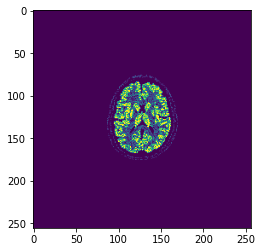

In [21]:
plt.imshow(inputsTrain_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

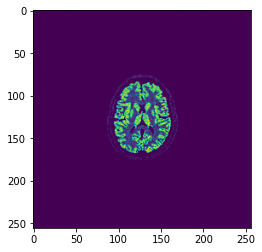

In [22]:
plt.imshow(outTrain_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )

In [23]:
# CONJUNTO DE TESTEO

if __name__ == '__main__':
    inputsTest = test_noisyImage[1]
    inputsTest = np.stack((inputsTest,)*3, axis=-3)
    inputsTest = torch.Tensor(inputsTest)
    outTest = unet(inputsTest)
    
gTtest = test_groundTruth[1]
gTtest = np.expand_dims((gTtest,)*3, axis=-3)
gTtest = torch.Tensor(gTtest)

inputsTest_np = inputsTest.detach().numpy()
outTest_np = outTest.detach().numpy()
gTtest_np = gTtest.detach().numpy()

# MSE antes y dsp

MSE_orig = MSE(inputsTest_np[0,0,:,:],gTtest_np[0,0,:,:])
MSE_test = MSE(outTest_np[0,0,:,:],gTtest_np[0,0,:,:])

print('MSE orig', MSE_orig)
print('MSE test', MSE_test)

MSE orig 0.3794829547405243
MSE test 0.21144960820674896


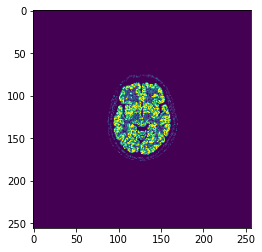

In [25]:
plt.imshow(inputsTest_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )

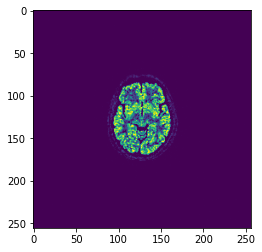

In [24]:
plt.imshow(outTest_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )